<div class="head0">
    <div class="head0__name">
        Diffusion equation with const drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the multidimensional Fokker-Planck equation by fast and accurate tensor based methods (1th order method).
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider 1D equation with constant drift
$$
    dx = f(x, t) \, dt + S d\beta,
    \quad
    d \beta \, d \beta^{\top} = Q dt,
    \quad
    \frac{\partial \rho}{\partial t} = - div \left[ f(x, t) \rho \right] + D \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
$$
    x \in \Omega = [-3, 3],
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
    \quad
     D = \frac{1}{2} S Q S^{\top} = 1,
$$
with 
$$
    f(x, t) = v = 3 = const.
$$

This equation has exact solution ([see this paper](http://www.icmp.lviv.ua/journal/zbirnyk.73/13002/art13002.pdf); note that there is a typo in the paper for this formula: $\pi$ is missed!)
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{4 \pi D t}}
        \exp{\left[
            - \frac
                {
                    \left( x - x_0 - v t \right)^2
                }
                {
                    4 D t
                }
        \right]},
$$
where $x_0$ is an initial condition. We can rewrite this equation in terms of the initial PDF $\rho_0(x)$ as
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0,
$$
which after accurate computations leads to analytic solution
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi s + 4 \pi D t}
            }
        \exp{ \left[
            - \frac
                {
                    (x - vt)^2
                }
                {
                    2  s + 4 D t
                }
        \right] },
$$
with the zero stationary ($t \rightarrow \infty$) solution.

In [2]:
D = 1.
v = 3.
s = 0.001

def func_f0(x, t):
    return v * np.ones(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    m = 0.
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rt(x, t):
    r = np.exp(-1. * (x - v * t)**2 / (2. * s + 4. * D * t))
    r/= np.sqrt(2. * np.pi * s + 4. * np.pi * D * t)
    return r.reshape(-1)

def func_rs(x):
    r = np.zeros(x.shape)
    return r.reshape(-1)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 1.0

x_poi = 500
x_min = -10.
x_max = +10.

<div class="head1">
    <div class="head1__name">
        Explicit solution by Runge–Kutta method
    </div>
</div>

We can solve this 1D equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + Q) \rho,
$$
where
$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = Q w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODE by 4th order Runge–Kutta method by standard scipy solver.

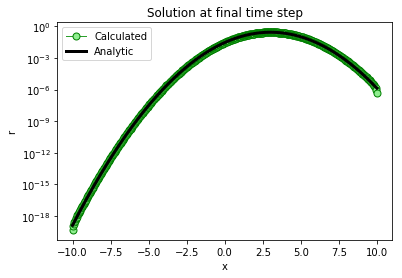

Number of time points    :     1000
Number of spatial points :      500
Error (relative norm)    : 3.18e-03    
Total time (sec)         : 1.08e+01    


In [4]:
_time = time.time()

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

n = x_poi
l = (x_max - x_min) / x_poi
X = np.linspace(x_min, x_max, x_poi)

I = np.eye(n)
Q_ = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q_ = (Q_ / 2 / l).toarray()
D_ = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D_ = (D_ / l / l).toarray()

def func_d(t, r):
    return D_ @ r

def func_q(t, r):
    return -1. * v * Q_ @ r

u = func_r0(X.reshape(1, -1))
for t in T[1:]:
    u0 = u
    w1 = solve_ivp(func_d, [t - h, t], u0).y[:, -1]
    v1 = solve_ivp(func_q, [t - h, t], w1).y[:, -1]
    u = v1

_time = time.time() - _time
    
u_calc = u
u_real = func_rt(X.reshape(1, -1), T[-1])

plt.plot(
    X, u_calc, label='Calculated',
    linewidth=1, color='tab:green', marker='o', markersize=7,
    markerfacecolor='lightgreen', markeredgecolor='g'
)
plt.plot(
    X, u_real, label='Analytic',
    linewidth=3, color='black'
)
plt.semilogy()
plt.title('Solution at final time step')
plt.xlabel('x')
plt.ylabel('r')
plt.legend(loc='best')
plt.show()


e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%x_poi)
print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)

<div class="head1">
    <div class="head1__name">
        Explicit solution by matrix exp.
    </div>
    <div class="head1__note">
        We can use the same approach but apply matrix exponent instead of the Runge–Kutta method.
    </div>
</div>

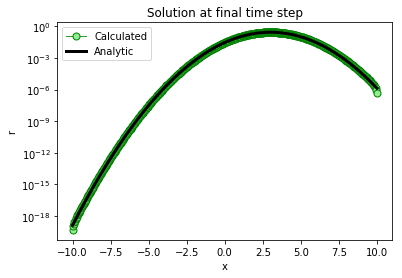

Number of time points    :     1000
Number of spatial points :      500
Error (relative norm)    : 3.18e-03    
Total time (sec)         : 9.74e-01    


In [5]:
_time = time.time()

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

n = x_poi
l = (x_max - x_min) / x_poi
X = np.linspace(x_min, x_max, x_poi)

I = np.eye(n)
J = np.eye(x_poi); #J[0, 0] = 0.; J[-1, -1] = 0.

Q_ = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q_ = (Q_ / 2 / l).toarray()
Q_ = -v * Q_
ZQ = expm(h * J @ Q_) @ J
D_ = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D_ = (D_ / l / l).toarray()
ZD = expm(h * J @ D_) @ J
    
u = func_r0(X.reshape(1, -1))
for t in T[1:]:
    u0 = u
    w1 = ZD @ u0
    v1 = ZQ @ w1
    u = v1

_time = time.time() - _time
    
u_calc = u
u_real = func_rt(X.reshape(1, -1), T[-1])

plt.plot(
    X, u_calc, label='Calculated',
    linewidth=1, color='tab:green', marker='o', markersize=7,
    markerfacecolor='lightgreen', markeredgecolor='g'
)
plt.plot(
    X, u_real, label='Analytic',
    linewidth=3, color='black'
)
plt.semilogy()
plt.title('Solution at final time step')
plt.xlabel('x')
plt.ylabel('r')
plt.legend(loc='best')
plt.show()


e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%x_poi)
print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [6]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|███████| 999/999 [01:05<00:00, 15.89step/s, Norm 1.80e+00]


In [7]:
SL.info()

---------- Solver
Format   : 1D, NP
Grid x   : poi =       500, min =  -10.0000, max =   10.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 3.91e-01, calc = 6.07e+01


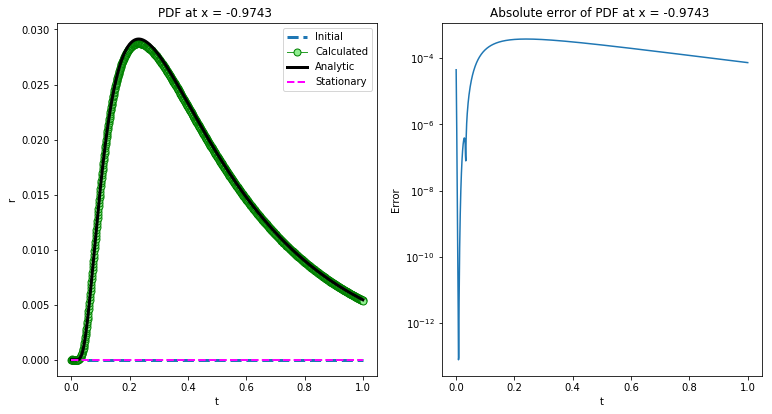

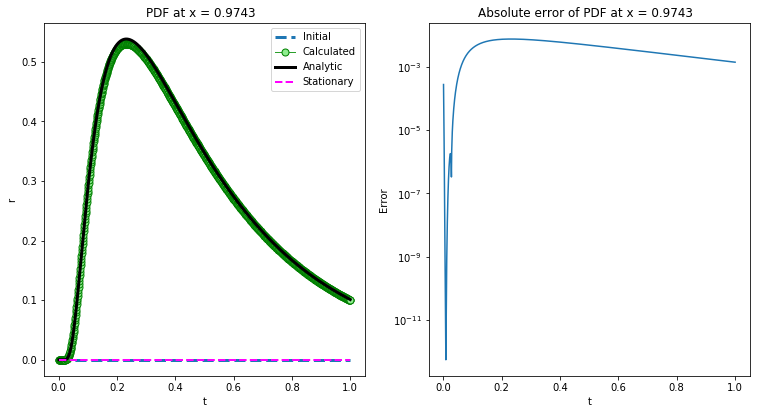

In [8]:
SL.plot_t(x=-1.0, is_err_abs=True)
SL.plot_t(x=+1.0, is_err_abs=True)

**Note** <span style="color: green;">Analytic solution is not vanish on the boundaries at selected time interval (but stationary solution will be zero), so we could not expect very good accuracy of our solver.<span>

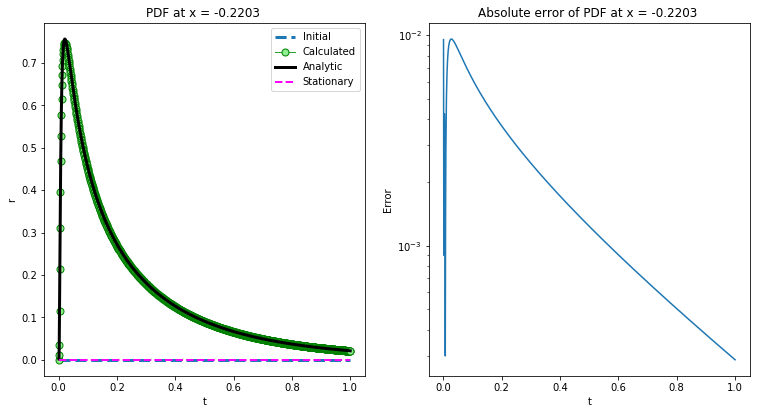

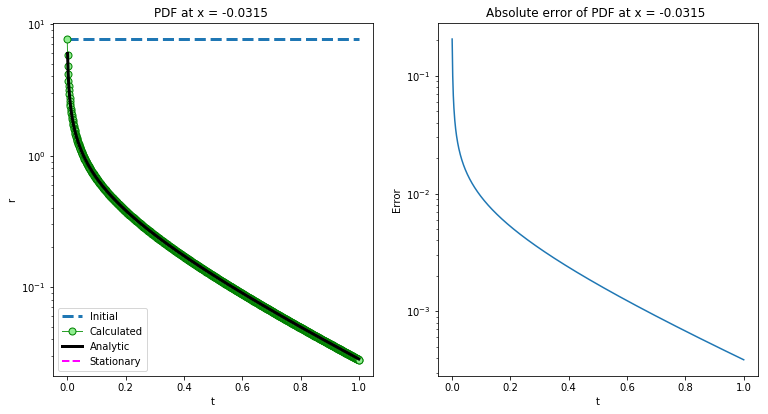

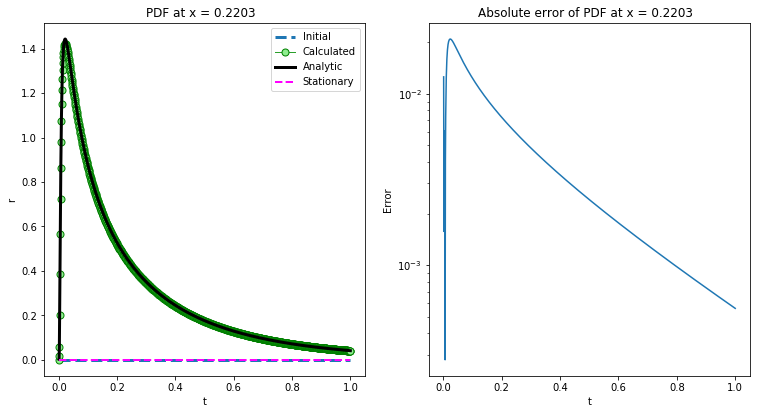

In [9]:
SL.plot_t(x=-0.2, is_err_abs=True)
SL.plot_t(x=+0.0, is_log=True, is_err_abs=True)
SL.plot_t(x=+0.2, is_err_abs=True)

**Note** <span style="color: green;">Solution is rather accurate until time 0.25.<span>

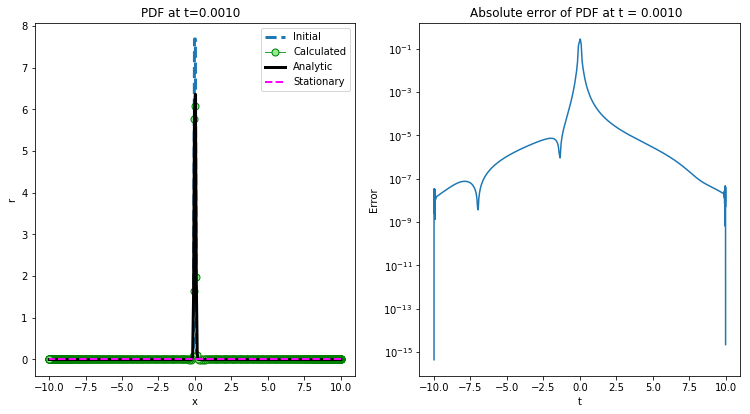

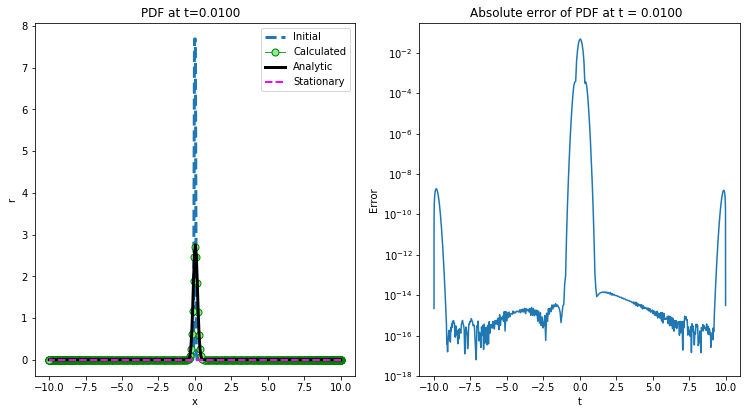

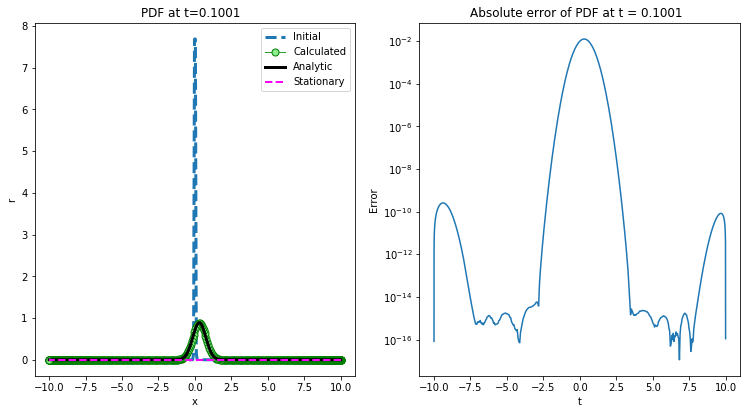

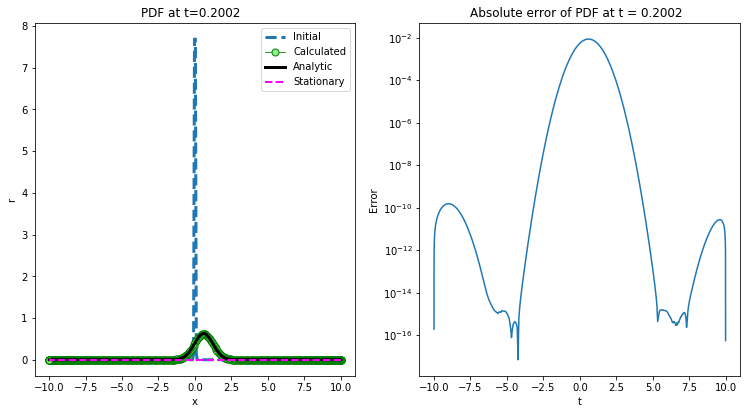

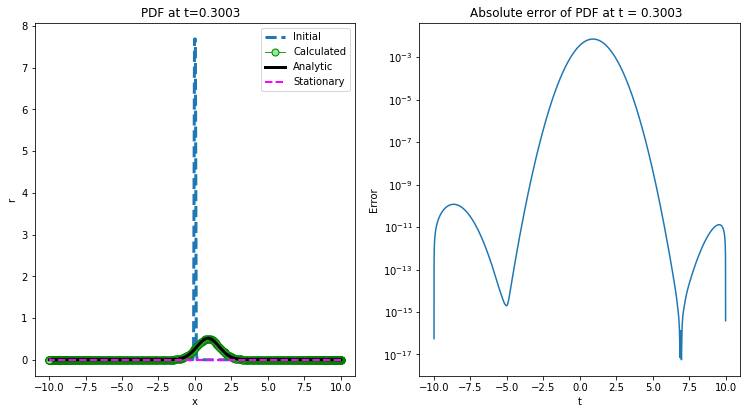

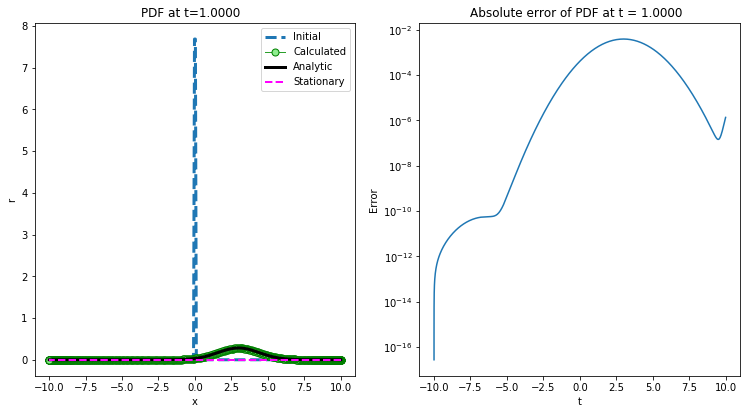

In [10]:
SL.plot_x(t=0.001, is_err_abs=True)
SL.plot_x(t=0.01, is_err_abs=True)
SL.plot_x(t=0.1, is_err_abs=True)
SL.plot_x(t=0.2, is_err_abs=True)
SL.plot_x(t=0.3, is_err_abs=True)
SL.plot_x(is_err_abs=True)

**Note** <span style="color: green;">Solution is not accurate at the final time step.<span>

<div class="head1">
    <div class="head1__name">
        Convergence analysis
    </div>
</div>

In [11]:
N = [10, 50, 100, 200, 300, 400, 500]
E = []

for n in N:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(t_poi, t_min, t_max)
    SL.set_grid_x(x_poi, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    E.append(e)

Solve: 100%|███████| 999/999 [01:30<00:00, 10.99step/s, Norm 1.80e+00]


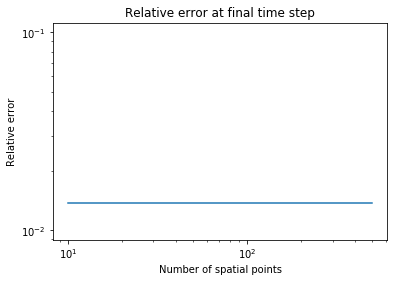



Solver info for n = 500 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =       500, min =  -10.0000, max =   10.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 1.09e+00, calc = 8.39e+01


In [12]:
plt.plot(N, E)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step')
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d : '%N[-1])
SL.info()

<div class="end"></div>